In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

import math 

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Scrub - Converting data types 

In [4]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [5]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [6]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [7]:
# Scrub - Treating Null values 

In [8]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [10]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [11]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [12]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

In [13]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

# Scrubbing - Outliers 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000179D4A0E898>,
      dtype=object)

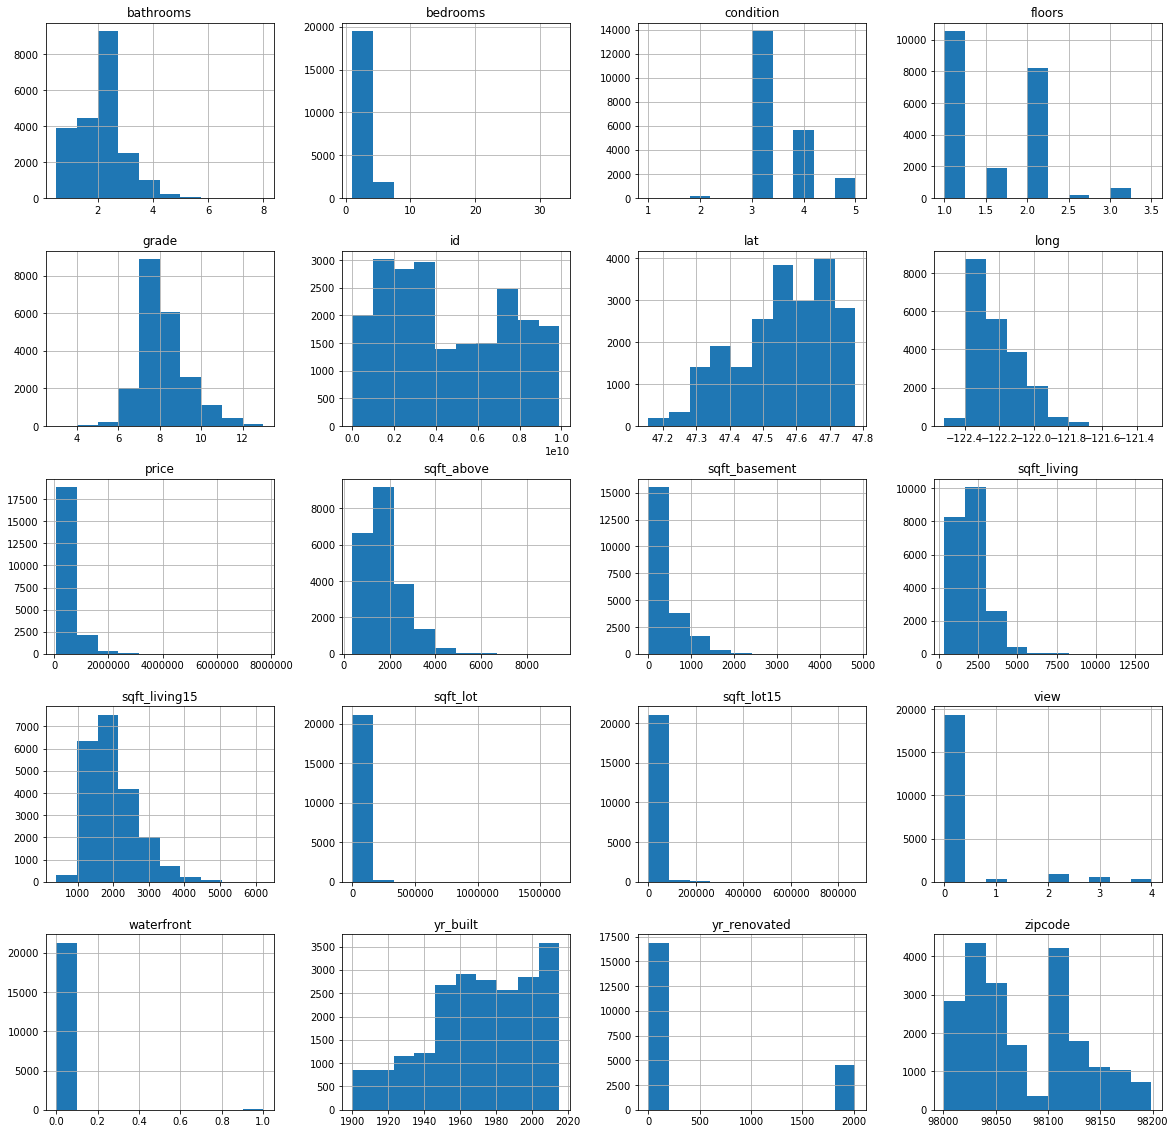

In [14]:
df.hist(figsize=(20,20))

# Exploring Categorical & Numerical Variables 

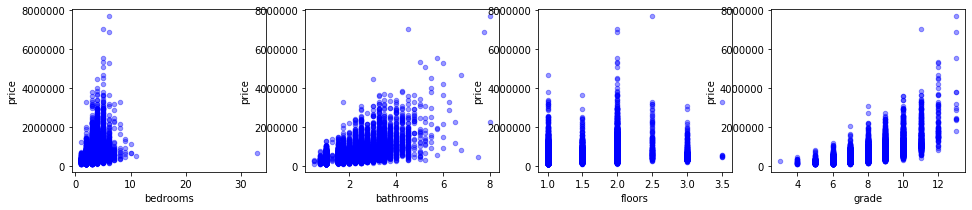

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

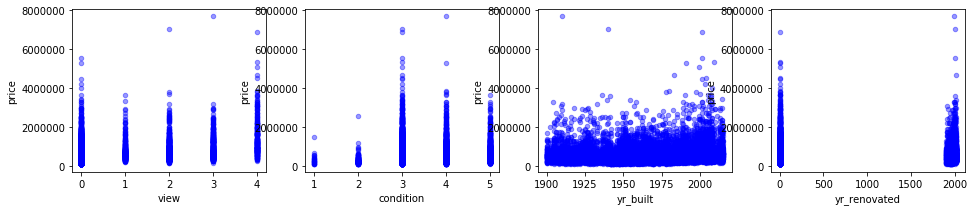

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Checking for Linear Relationships to find the best data
## Comment/uncomment cell below for outlier removal code 

In [17]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)

indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

#drop houses over a million
indexNames = df[df['price'] >= 1000000].index
df.drop(indexNames, inplace=True)

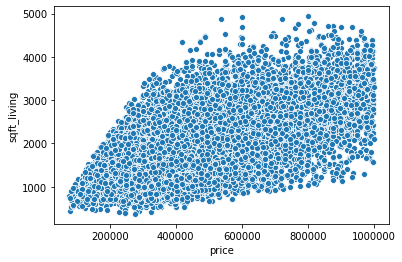

In [18]:
sns.scatterplot(x='price', y='sqft_living', data=df)

(array([ 540., 3306., 4938., 4309., 3102., 1763.,  929.,  366.,  117.,
          24.]),
 array([ 370.,  827., 1284., 1741., 2198., 2655., 3112., 3569., 4026.,
        4483., 4940.]),
 <a list of 10 Patch objects>)

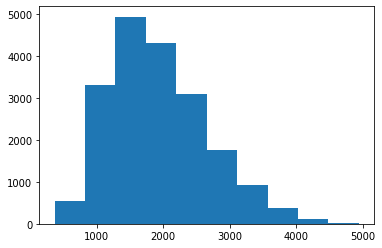

In [19]:
# Histogram of variable 

plt.hist(df['sqft_living'])

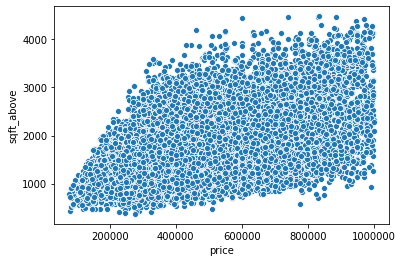

In [20]:
sns.scatterplot(x='price', y='sqft_above', data=df)

(array([ 624., 4663., 5683., 3360., 2057., 1475.,  877.,  447.,  160.,
          48.]),
 array([ 370.,  781., 1192., 1603., 2014., 2425., 2836., 3247., 3658.,
        4069., 4480.]),
 <a list of 10 Patch objects>)

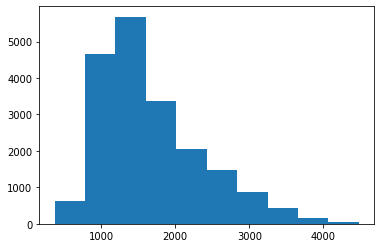

In [21]:
plt.hist(df['sqft_above'])

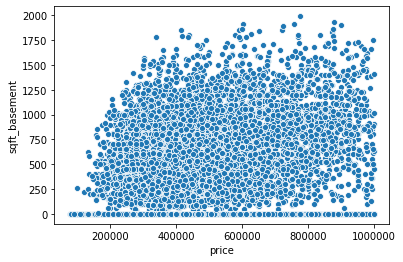

In [22]:
sns.scatterplot(x='price', y='sqft_basement', data=df)

(array([12646.,  1130.,  1480.,  1505.,  1257.,   736.,   396.,   169.,
           57.,    18.]),
 array([   0.,  199.,  398.,  597.,  796.,  995., 1194., 1393., 1592.,
        1791., 1990.]),
 <a list of 10 Patch objects>)

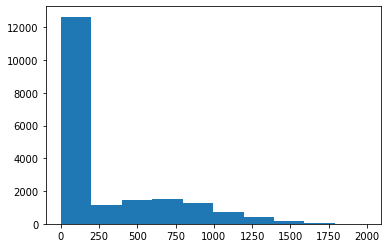

In [23]:
plt.hist(df['sqft_basement'])

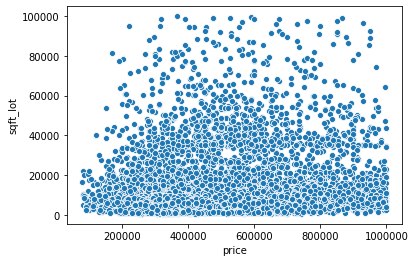

In [24]:
sns.scatterplot(x='price', y='sqft_lot', data=df)

(array([15129.,  2828.,   450.,   410.,   257.,   130.,    69.,    48.,
           39.,    34.]),
 array([  520. , 10459.6, 20399.2, 30338.8, 40278.4, 50218. , 60157.6,
        70097.2, 80036.8, 89976.4, 99916. ]),
 <a list of 10 Patch objects>)

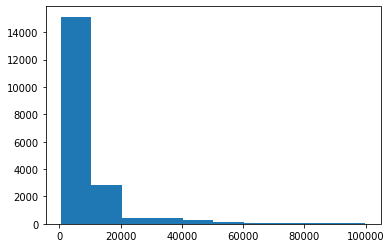

In [25]:
plt.hist(df['sqft_lot'])

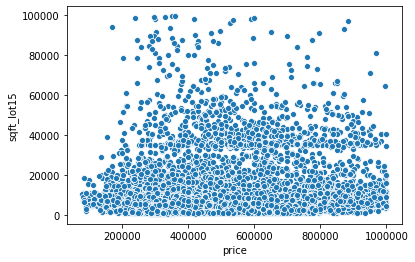

In [26]:
sns.scatterplot(x='price', y='sqft_lot15', data=df)

(array([15842.,  2394.,   329.,   403.,   206.,   103.,    43.,    26.,
           26.,    22.]),
 array([  651. , 10517.5, 20384. , 30250.5, 40117. , 49983.5, 59850. ,
        69716.5, 79583. , 89449.5, 99316. ]),
 <a list of 10 Patch objects>)

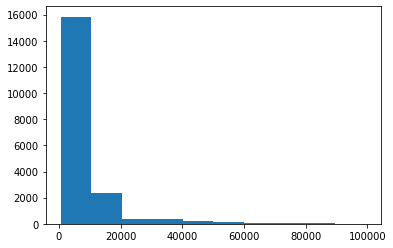

In [27]:
plt.hist(df['sqft_lot15'])

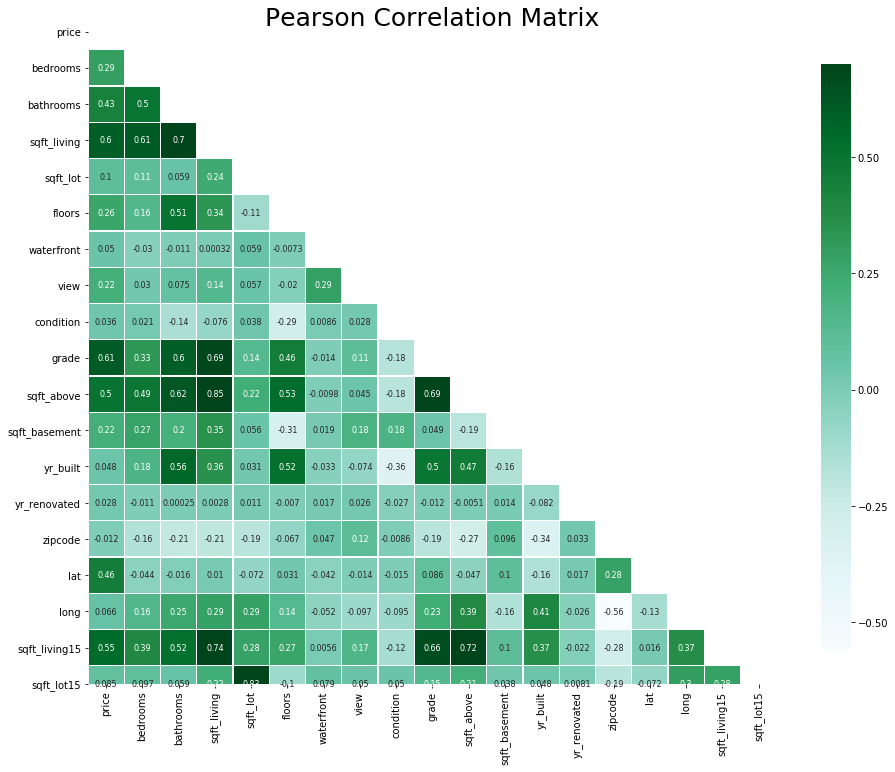

In [30]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# Clearly need to remove outliers and perform a log function
## Comment cell to remove outliers 

# Performing Log Functions on numerical_df

In [28]:
df_num = df[['price', 'bedrooms', 'bathrooms','floors', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019732EC8A20>,
      dtype=object)

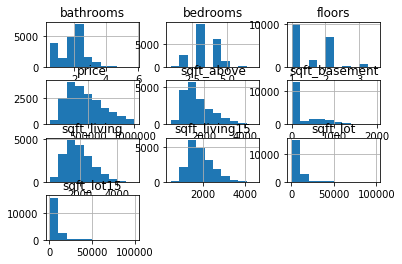

In [29]:
df_num.hist()

In [30]:
#created a logged numerical df 

df_sqft_logs = pd.DataFrame([])
df_sqft_logs = df_num

In [31]:
df_sqft_logs['sqft_living_log'] = np.log(df_sqft_logs['sqft_living'])
df_sqft_logs['sqft_above_log'] = np.log(df_sqft_logs['sqft_above'])
df_sqft_logs['sqft_lot_log'] = np.log(df_sqft_logs['sqft_lot'])
df_sqft_logs['sqft_basement_log'] = np.log(df_sqft_logs['sqft_basement'])
df_sqft_logs['sqft_living15_log'] = np.log(df_sqft_logs['sqft_living15'])
df_sqft_logs['sqft_lot15_log'] = np.log(df_sqft_logs['sqft_lot15'])
df_sqft_logs['bathrooms'] = np.log(df_sqft_logs['bathrooms'])
df_sqft_logs['bedrooms'] = np.log(df_sqft_logs['bedrooms'])
df_sqft_logs['floors'] = np.log(df_sqft_logs['floors'])

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
pd.DataFrame.drop(df_num, columns=['sqft_basement_log'], inplace=True)

In [33]:
# Data is now evenly distributed, lets check for linearity 

In [34]:
headers = list(df_sqft_logs)

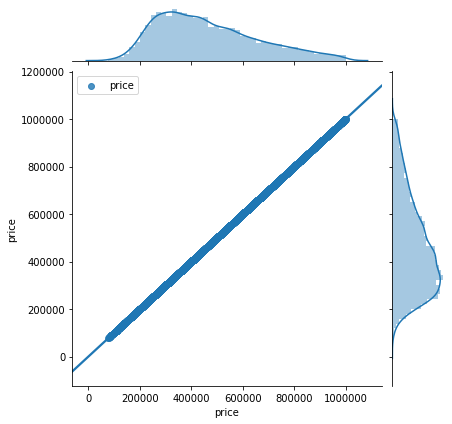

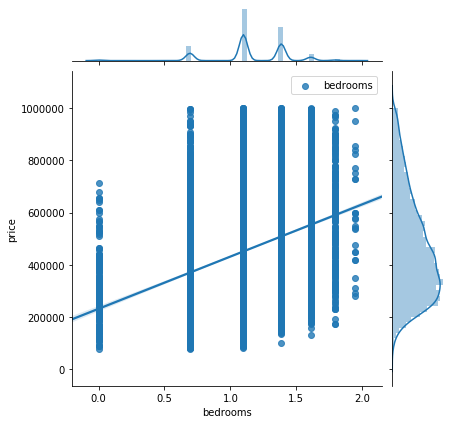

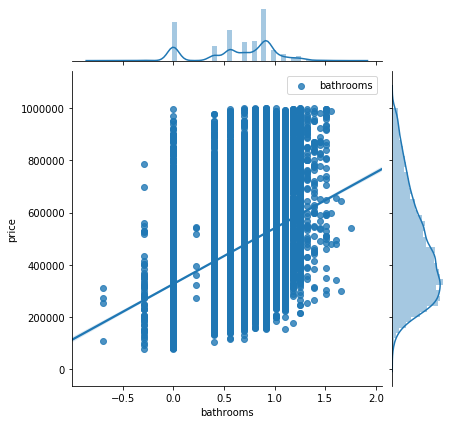

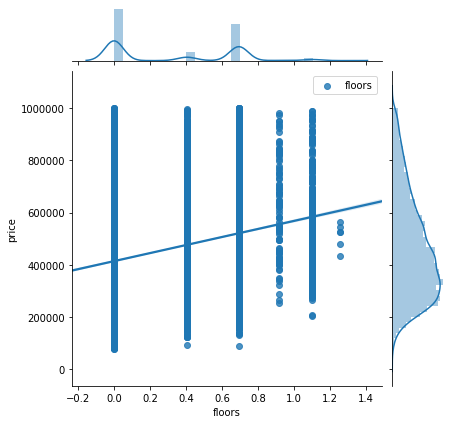

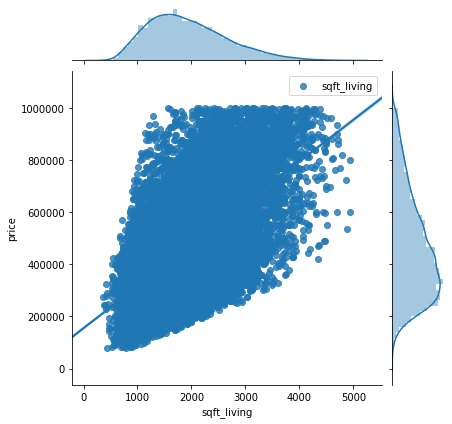

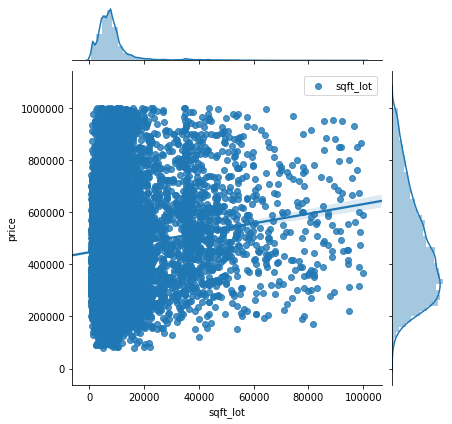

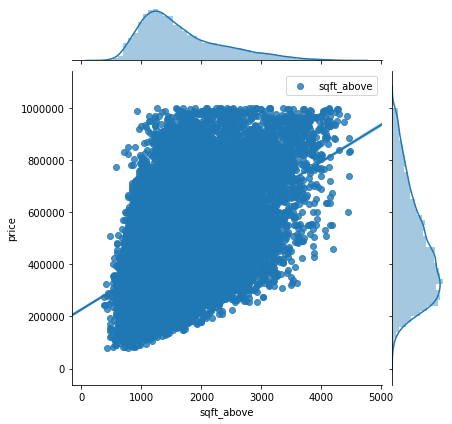

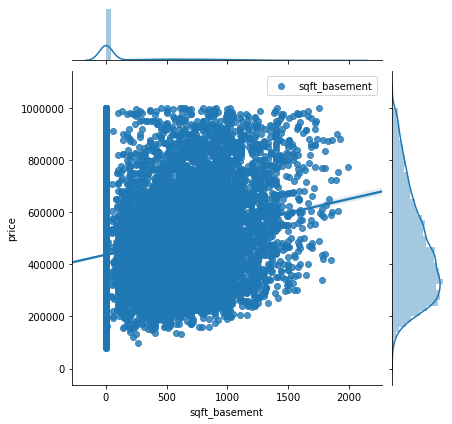

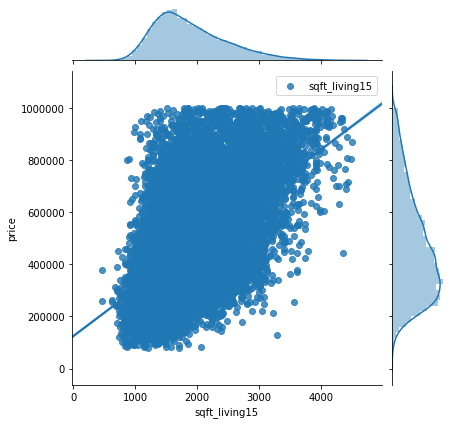

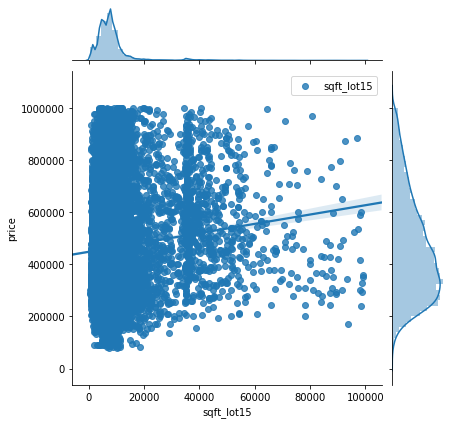

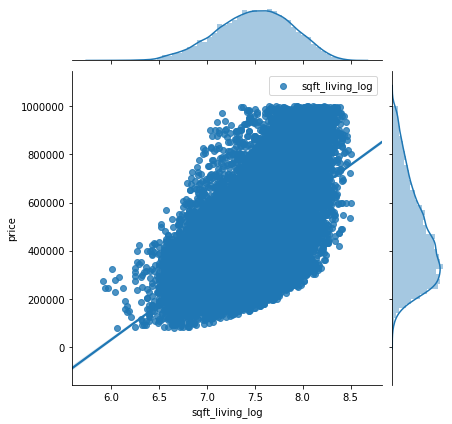

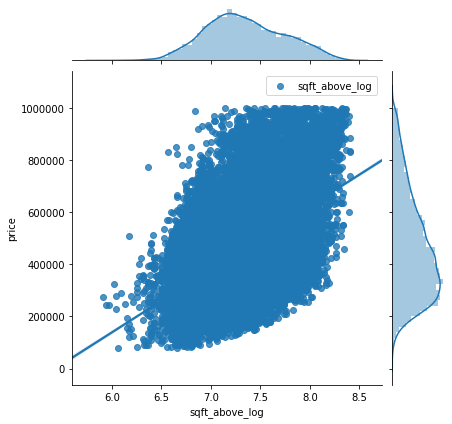

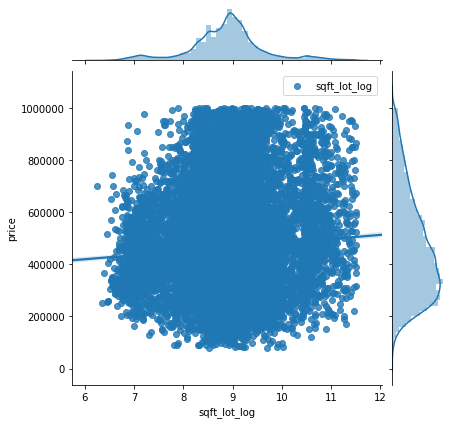

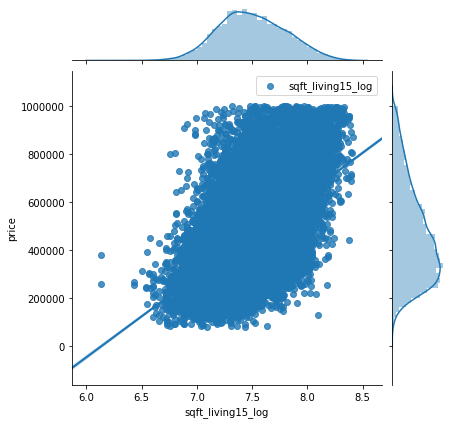

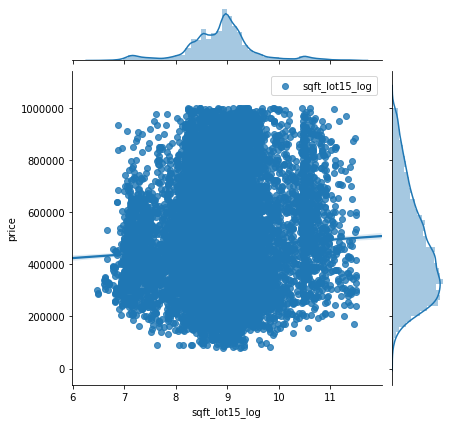

In [35]:
for column in headers:
    sns.jointplot(x=column, y='price',
                 data=df_sqft_logs,
                 kind='reg',
                 label=column,
                 )
    plt.legend()
    plt.show()

# Encoding Categorical Variables

In [36]:
df_cat = df[['view', 'condition', 'waterfront','grade', 'yr_built', 'yr_renovated']].copy()

In [37]:
df_cat['condition'] = df_cat['condition'].astype("int")
df_cat['waterfront'] =  df_cat['waterfront'].astype("int")

In [38]:
df_cat.columns = df_cat.columns.astype("str")

In [39]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19394 entries, 0 to 21596
Data columns (total 6 columns):
view            19394 non-null float64
condition       19394 non-null int32
waterfront      19394 non-null int32
grade           19394 non-null int64
yr_built        19394 non-null int64
yr_renovated    19394 non-null float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 909.1 KB


In [40]:
df_cat = pd.get_dummies(df_cat, drop_first=True) #pd
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19394 entries, 0 to 21596
Data columns (total 6 columns):
view            19394 non-null float64
condition       19394 non-null int32
waterfront      19394 non-null int32
grade           19394 non-null int64
yr_built        19394 non-null int64
yr_renovated    19394 non-null float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 909.1 KB


# Combine categorical and numerical data

In [41]:
df_combo = pd.concat([df_sqft_logs, df_cat], axis=1)
df_combo.head()  

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,...,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log,view,condition,waterfront,grade,yr_built,yr_renovated
0,221900.0,1.098612,0.000000,0.000000,1180,5650,1180,0.0,1340,5650,...,7.073270,8.639411,7.200425,8.639411,0.0,3,0,7,1955,0.0
1,538000.0,1.098612,0.810930,0.693147,2570,7242,2170,400.0,1690,7639,...,7.682482,8.887653,7.432484,8.941022,0.0,3,0,7,1951,1991.0
2,180000.0,0.693147,0.000000,0.000000,770,10000,770,0.0,2720,8062,...,6.646391,9.210340,7.908387,8.994917,0.0,3,0,6,1933,1933.0
3,604000.0,1.386294,1.098612,0.000000,1960,5000,1050,910.0,1360,5000,...,6.956545,8.517193,7.215240,8.517193,0.0,5,0,7,1965,0.0
4,510000.0,1.098612,0.693147,0.000000,1680,8080,1680,0.0,1800,7503,...,7.426549,8.997147,7.495542,8.923058,0.0,3,0,8,1987,0.0


In [42]:
for cat_names in df_combo.iloc[:,11:].columns:
    df_combo[cat_names] = df_combo[cat_names].astype('category')

In [43]:
# OLS Regression

In [44]:
# OLS Regression

#It didnt seem to work!

import statsmodels.api as sm
import statsmodels.formula.api as smf

col_names = df_combo.describe().columns[1:11] #What does this?

results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p_value ']] #creating an array of results we care about

for idx, val in enumerate(col_names):
    print('price~' + val)
    f = 'price~' + val
    model = smf.ols(formula=f, data=df_combo).fit()
    X_new = pd.DataFrame({val: [df_combo[val].min(), df_combo[val].max()]});
    preds = model.predict(X_new)
    results.append({val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]})

    print(results[idx+1])
    print(model.summary())

price~bedrooms
{0.08183418312055257, 0.0, 'bedrooms', 199828.7774547661, 232191.78778389437}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1728.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:36:17   Log-Likelihood:            -2.6289e+05
No. Observations:               19394   AIC:                         5.258e+05
Df Residuals:                   19392   BIC:                         5.258e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

{0.046469500340906245, 1.1278606624760168e-202, 106.6324946852408, 437228.7829403785, 'sqft_basement'}
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     945.1
Date:                Sat, 15 Feb 2020   Prob (F-statistic):          1.13e-202
Time:                        20:36:17   Log-Likelihood:            -2.6325e+05
No. Observations:               19394   AIC:                         5.265e+05
Df Residuals:                   19392   BIC:                         5.265e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [45]:
df_num.corr()

,price,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,sqft_living_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15_log
price,1.000000,0.286067,0.415529,0.277953,0.598499,0.100672,0.504128,0.215568,0.545884,0.085058,0.578074,0.491375,0.060529,0.532363,0.049849
bedrooms,0.286067,1.000000,0.511232,0.189695,0.606090,0.109925,0.489838,0.251943,0.397170,0.100982,0.651716,0.537294,0.223587,0.414055,0.200766
bathrooms,0.415529,0.511232,1.000000,0.501232,0.689767,0.061029,0.604818,0.206337,0.514542,0.061075,0.729549,0.643670,0.010520,0.533743,0.011246
floors,0.277953,0.189695,0.501232,1.000000,0.365141,-0.097696,0.565710,-0.313702,0.293131,-0.091429,0.366855,0.570659,-0.308059,0.282090,-0.291739
sqft_living,0.598499,0.606090,0.689767,0.365141,1.000000,0.240816,0.845720,0.353441,0.739406,0.224687,0.971921,0.834625,0.304056,0.725588,0.282039
sqft_lot,0.100672,0.109925,0.061029,-0.097696,0.240816,1.000000,0.221692,0.055631,0.279143,0.833287,0.221311,0.213398,0.810442,0.270834,0.727654
sqft_above,0.504128,0.489838,0.604818,0.565710,0.845720,0.221692,1.000000,-0.190914,0.717809,0.214836,0.810078,0.973339,0.265635,0.689681,0.250595
sqft_basement,0.215568,0.251943,0.206337,-0.313702,0.353441,0.055631,-0.190914,1.000000,0.103520,0.037727,0.364754,-0.164788,0.094212,0.126815,0.080354
sqft_living15,0.545884,0.397170,0.514542,0.293131,0.739406,0.279143,0.717809,0.103520,1.000000,0.284013,0.710390,0.694214,0.344597,0.981477,0.352820
sqft_lot15,0.085058,0.100982,0.061075,-0.091429,0.224687,0.833287,0.214836,0.037727,0.284013,1.000000,0.206398,0.205671,0.724602,0.274555,0.815424


In [46]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [47]:
# Non encoded, assumptions of regression not met in regression below 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

In [48]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [49]:
from statsmodels.formula.api import ols

In [50]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1664.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:36:17   Log-Likelihood:            -2.5569e+05
No. Observations:               19394   AIC:                         5.114e+05
Df Residuals:                   19378   BIC:                         5.115e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    924.147    502.457      0.000    4.63e+05    4.66e+05
bedrooms       -1.36e+04   1216.365    -11.180      0.000    -1.6e+04   -1.12e+04
bathrooms      1.752e+04   1585.070     11.053      0.000    1.44e+04    2.06e+04
sqft_living    5.256e+04   9598.333      5.476      0.000    3.37e+04    7.14e+04
sqft_lot        271.3396   1690.345      0.161      0.872   -3041.883    3584.563
floors         2.642e+04   1337.514     19.753      0.000    2.38e+04     2.9e+04
waterfront     5699.7366    970.925      5.870      0.000    3796.640    7602.834
view           1.062e+04   1007.081     10.543      0.000    8643.847    1.26e+04
condition      1.192e+04   1010.765     11.789      0.000    9934.705    1.39e+04
grade           8.87e+04   1484.597     59.745      0.000    8.58e+04    9.16e+04
sqft_above    -1.175e+04   9091.320     -1.292      0.196   -2.96e+04    6073.419
sqft_basement  5806.8854   5128.023      1.132      0.257   -4244.482    1.59e+04
yr_built      -7.535e+04   1298.075    -58.048      0.000   -7.79e+04   -7.28e+04
yr_renovated    928.7505    931.753      0.997      0.319    -897.565    2755.066
sqft_living15  3.595e+04   1534.457     23.426      0.000    3.29e+04     3.9e+04
sqft_lot15    -1.143e+04   1690.401     -6.764      0.000   -1.47e+04   -8121.025
==============================================================================
Omnibus:                      401.867   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.942
Skew:                           0.301   Prob(JB):                    7.37e-104
Kurtosis:                       3.475   Cond. No.                         33.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# Same as above but removed yr_renovated','sqft_basement', 

outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']

cols_removed = ['sqft_above', 'sqft_living15', 'waterfront']

In [84]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [85]:
from statsmodels.formula.api import ols

In [86]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2467.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:37:37   Log-Likelihood:            -2.5575e+05
No. Observations:               19394   AIC:                         5.115e+05
Df Residuals:                   19383   BIC:                         5.116e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    927.235    500.784      0.000    4.63e+05    4.66e+05
bedrooms        -1.4e+04   1219.506    -11.476      0.000   -1.64e+04   -1.16e+04
bathrooms      2.058e+04   1558.890     13.204      0.000    1.75e+04    2.36e+04
sqft_living    4.855e+04   1924.441     25.227      0.000    4.48e+04    5.23e+04
floors         2.065e+04   1196.335     17.265      0.000    1.83e+04     2.3e+04
view           1.373e+04    956.590     14.351      0.000    1.19e+04    1.56e+04
condition      1.238e+04   1010.382     12.253      0.000    1.04e+04    1.44e+04
grade           8.74e+04   1484.786     58.862      0.000    8.45e+04    9.03e+04
yr_built      -7.681e+04   1287.171    -59.676      0.000   -7.93e+04   -7.43e+04
sqft_living15   3.23e+04   1500.032     21.533      0.000    2.94e+04    3.52e+04
sqft_lot15    -1.177e+04    994.070    -11.836      0.000   -1.37e+04   -9817.752
==============================================================================
Omnibus:                      384.866   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.481
Skew:                           0.299   Prob(JB):                     1.12e-97
Kurtosis:                       3.441   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_combo).fit()
model.summary()

In [91]:
outcome = 'price'

x_cols = ['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']


In [92]:
# Some brief preprocessing
df.columns = [col.replace(' ', '_') for col in df.columns]
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,-0.362971,-1.488007,-1.035852,-0.392367,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.714531,-0.646345,-0.535146,-0.512471,98178,47.5112,-122.257,-0.937865,-0.384713
1,6414100192,2014-12-09,538000.0,-0.362971,0.317065,0.871625,-0.242271,0.981556,-0.048758,-0.255718,...,-0.496007,0.714725,0.370364,-0.672068,1.972214,98125,47.7210,-122.319,-0.348648,-0.169955
2,5631500400,2015-02-25,180000.0,-1.518307,-1.488007,-1.598489,0.017757,-0.876822,-0.048758,-0.255718,...,-1.500766,-1.306445,-0.646345,-1.288215,1.899832,98028,47.7379,-122.233,1.385334,-0.124283
3,2487200875,2014-12-09,604000.0,0.792365,1.400108,0.034531,-0.453650,-0.876822,-0.048758,-0.255718,...,-0.496007,-0.902211,1.666668,-0.192842,-0.512471,98136,47.5208,-122.393,-0.904195,-0.454895
4,1954400510,2015-02-18,510000.0,-0.362971,-0.043949,-0.349709,-0.163263,-0.876822,-0.048758,-0.255718,...,0.508752,0.007316,-0.646345,0.560227,-0.512471,98074,47.6168,-122.045,-0.163465,-0.184640


In [93]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2467.
Date:                Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:38:13   Log-Likelihood:            -2.5575e+05
No. Observations:               19394   AIC:                         5.115e+05
Df Residuals:                   19383   BIC:                         5.116e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.643e+05    927.235    500.784      0.000    4.63e+05    4.66e+05
bedrooms        -1.4e+04   1219.506    -11.476      0.000   -1.64e+04   -1.16e+04
bathrooms      2.058e+04   1558.890     13.204      0.000    1.75e+04    2.36e+04
sqft_living    4.855e+04   1924.441     25.227      0.000    4.48e+04    5.23e+04
floors         2.065e+04   1196.335     17.265      0.000    1.83e+04     2.3e+04
view           1.373e+04    956.590     14.351      0.000    1.19e+04    1.56e+04
condition      1.238e+04   1010.382     12.253      0.000    1.04e+04    1.44e+04
grade           8.74e+04   1484.786     58.862      0.000    8.45e+04    9.03e+04
yr_built      -7.681e+04   1287.171    -59.676      0.000   -7.93e+04   -7.43e+04
sqft_living15   3.23e+04   1500.032     21.533      0.000    2.94e+04    3.52e+04
sqft_lot15    -1.177e+04    994.070    -11.836      0.000   -1.37e+04   -9817.752
==============================================================================
Omnibus:                      384.866   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.481
Skew:                           0.299   Prob(JB):                     1.12e-97
Kurtosis:                       3.441   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression model Validation

In [110]:
y = df['price']

X = df[['bedrooms', 'bathrooms', 'sqft_living',
       
        'floors', 'view', 'condition', 'grade',
       'yr_built', 
       'sqft_living15', 'sqft_lot15']]



# Perform a Train-Test Split

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

14545 4849 14545 4849


# Apply your model to the train set 

In [114]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [115]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [116]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Calculate predictions on training and test sets 

In [117]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [118]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [119]:
y_hat_test

array([417921.19553166, 765526.13007805, 602855.85187968, ...,
       590341.01097497, 342511.39925159, 442205.57553117])

# Calculate training and test residuals 

In [120]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate Mean Squared Error

In [121]:
from sklearn.metrics import mean_squared_error

In [122]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 16703351970.352978
Test Mean Squarred Error: 16557647309.79753


In [140]:
import math 

print(math.sqrt(test_mse))

127728.03222027721


# Evaluate the effect of train-test split size 

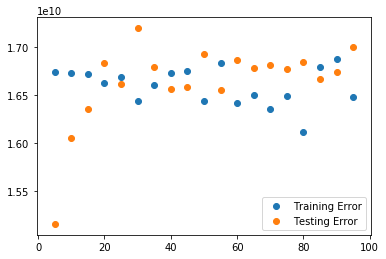

In [126]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))

plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

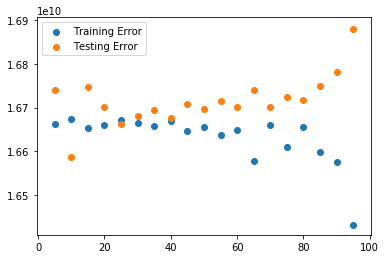

In [127]:
random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [128]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

# Train-test split 

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [130]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

15515 3879 15515 3879


# Fit the model

In [131]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

# Residuals and MSE

In [132]:
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

16314450214.864172